$\newcommand{\similarity}{\mathrm{similarity}}$
$\newcommand{\update}{{\small\mathrm{UPDATE}}}$
$\newcommand{\aggregate}{{\small\mathrm{AGGREGATE}}}$



**After this laboratory you should be able to**
- Explain the GNN framework
- Understand where neural networks come in.
- Understand the aggregate and update functions

## Resources

**Exaplanations**
- [Video explanation - WelcomeAIOverlords](https://www.youtube.com/watch?v=2KRAOZIULzw&t=1s) with [blog post](https://blog.zakjost.com/post/gcn_citeseer/)
- [Video explanation 2 - Coffe break](https://www.youtube.com/watch?v=me3UsMm9QEs)
- [Video tutorial 3 - DeepFindr](https://www.youtube.com/watch?v=fOctJB4kVlM&t)
- [Introductory Article](https://distill.pub/2021/gnn-intro/)

**Relevant papers**
- GraphSage paper [Inductive Representation Learning on Large Graphs](https://cs.stanford.edu/people/jure/pubs/graphsage-nips17.pdf),  [arvix link](https://arxiv.org/abs/1706.02216)
- GCN paper [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/pdf/1609.02907)
- GAT paper [Graph Attention Networks](https://arxiv.org/abs/1710.10903)

# GNN Framework

## Differences from simple datatypes

**CNN**

Photo from cs224w 2021  
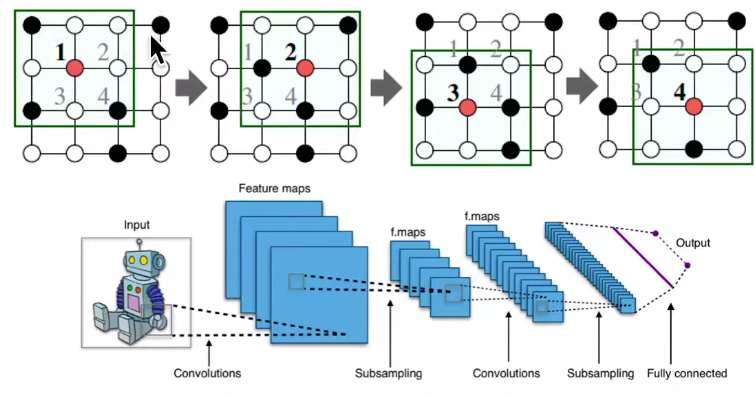

Let  
$G$ be a graph with $n$ nodes in the node set $V$ and $m$ edges.  
For a node $v \in V$ we denote $N(v)$ the size of the neighbourhood ov $v$.  
$X \in \mathbb R^{m \times n}$ is a matrix of **node features**. If there is no feature we can use one-hot encode the node or put a vector of 1s

photo from [DeepFindr](https://www.youtube.com/watch?v=ABCGCf8cJOE&t)  
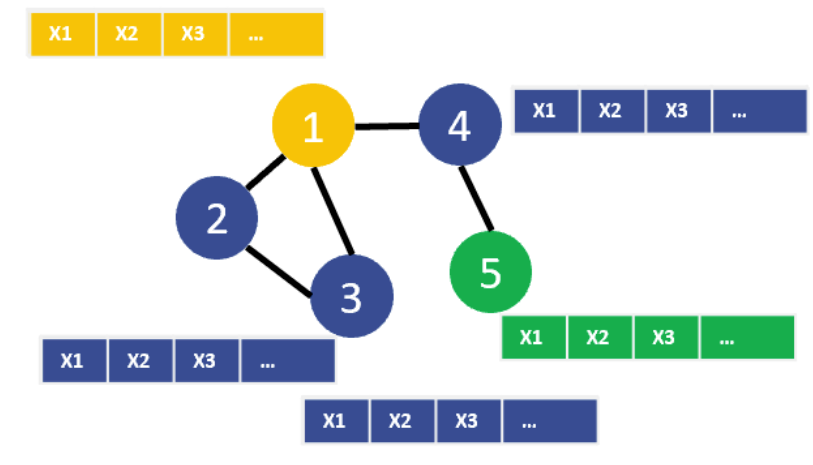

Key differences between simple datatypes (like images) and graph
1. Non-euclidean structure
    - There is no fixed notion of locality (there is no top left or bottom right)
    - If we are to replicate image convolutions there is no concept of "sliding window"
3. The network must be **permutation-invariant** (Nodes have no ordering, graphs can be isomorphic, if we pass nodes in a different order we should get the same results). 
    - Usually neural networks care about ordering
4. The GNN must be able to work with graph of different sizes and shapes. 
    - Most neural networks have fixed input size. We cannot "resize a graph" like we do with images. Therefore our framework must be flexible

*Thought experiment*  
Think about why using the adjacency matrix as an input (flatten and feed into a MLP) is **not** a good idea 
    


## Message passing 

**Task**: Train a model that can compute relevant node embeddings for the given ML task

*Intuition:* Similar to convolutions, we want to capture neighbourhoods of one node. At each iteration we want to get some information from the neighbourhood. After some iterations have passed we want our **node embedding** to contain information from multiple parts of our graph.


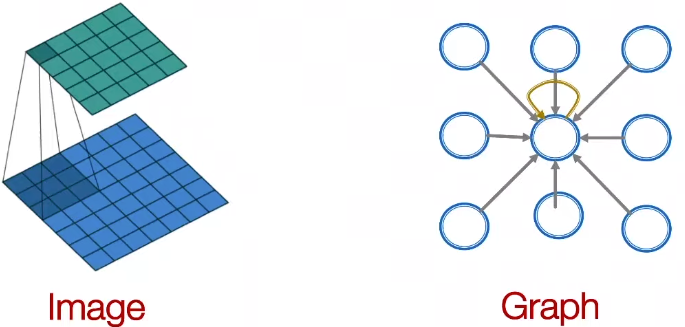

**Main formula**  
For each node $u \in V$ let  $h_u^{(k)}$ be a **hidden embedding** computed at step $k$. The update step can be expressed as follows:

$$
\begin{align}
h_u^{(k+1)} &= \update^{(k)}\left(h_u^{(k)}, \aggregate^{(k)} \left(\right\{h_v^{(k)}, \forall v \in N(u)\left\}\right)\right) \\
&= \update^{(k)}\left(h_u^{(k)}, m^{(k)}_{N(u)})\right)
\end{align}
$$
Where $\update$ and $\aggregate$ are arbitrary differentiable functions and $m_N(u)$ is the aggregated message from $u$'s neighbourhood $N(u)$.

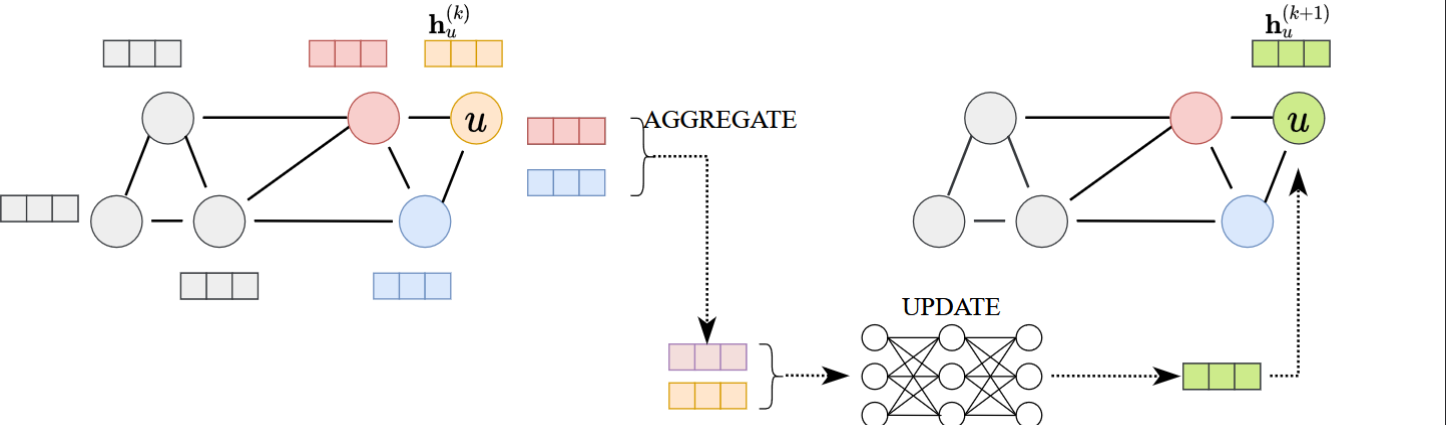

**Algorithm**
1. At step $k = 0$ the initial embeddings are the input features for all nodes $h_u^{0} = x_u \ \forall u \in V$
2. At each step $k$ the $\aggregate$ function takes as input the **set of embeddings** of the nodes in $u$’s neighborhood $N(u)$ and generates a message $m^{(k)}_N(u)$
based on this aggregated neighborhood information. The $\update$ function update then combines the message $m_N(u)$ with the previous embedding $h^{(k)}_u$

After some steps the information will propagate through the network and the embeddings should contain information from neighbours (Notice the mixed embeddings)

photo from [here](https://www.youtube.com/watch?v=ABCGCf8cJOE&t)  
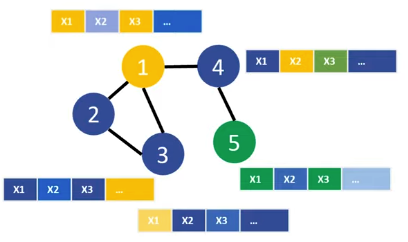

**What type of information propagates?**
- **Structural information** about the graph -- after $k$ iterations a the embedding of a node might encode the degree of his neighbours. Example: in molecular graphs we can use degree information to infer atom types and *structural motifs* (like benzene rings)
- **Feature based** -- after $k$ iterations a the embedding of a node contains information about the neighbours features

### Computation graph representation

photo from cs224w 2021  
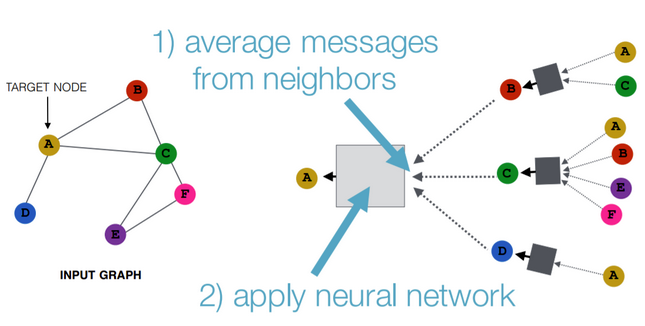

Node neighbourhood defines the **node computation graph**. We can unfold the graph a few hops to generate a computation graph **per node**.

Using this representation GNNs can be thought as a 2-step process
1. Find the node computation graph
2. Propagate information over the computation graph

**Remark**
- The number of layers in the neural network represents the number of hops we make in the graph. The first layer gets information from node features, the $k$th layer gets information from nodes $k$ steps away

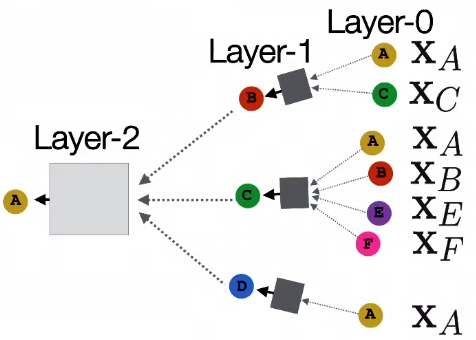

# The NN in GNN

**Message passing**:
$$ h_u^{(k)} = \sigma\left( W_{\text{self}}^{(k)}h_u^{(k-1)} + W_{\text{neigh}}^{(k)} \sum_{v \in N(u)}h_v^{(k-1)} + b^{(k)} \right)$$
Where
- $W_{\text{self}}^{(k)}, W_{\text{neigh}}^{(k)} \in R^{d^{(k)} \times d^{(k-1)}}$ are the **trainable parameters** (weights)
- $b^{(k)} \in R^{d^{(k)}}$ is the bias term
- $\sigma$ is a nonlinearity function (ReLU, tanh, sigmoid etc)

**Important remark** - The weight matrices $W$ are shared between different nodes -> All nodes use the $W$ matrices

If we use the aggregate-update framework:

$$m_{N(u)} = \aggregate \left(\left\{h_v, \forall v \in N(u)\right\}\right) = \sum_{v \in N(u)}h_v$$

$$\update\left(h_u, m_{N(u)}\right) = \sigma\left( W_{\text{self}} h_u + W_{\text{neigh}} m_{N(u)}\right)$$

**Matrix form**  
Let $A$ be the adjacency matrix of the graph. Let $H$ be the embedding matrix (each row is a node embedding)

photo from cs224w 2021  
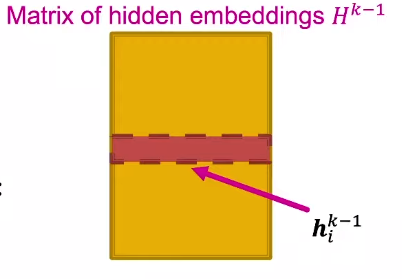

We can write the $\aggregate$ function as follows:
$$H^{(k)} = AH^{(k-1)}$$

**The self loop trick**  
Notice that the update step just adds information from the current node embedding. We can combine the steps if we add a *self-loop*. After we add the self-loop the $\aggregate$ function will take into consideration the current node embedding too.  
Now we don't need an explicit update function, we can do the update step through the aggretation method. In matrix form:

$$H^{(k+1)} = \sigma\left(\underbrace{(A + I)}_{\tilde{A}}H^{(k-1)}W^{(k)}\right)$$

**Remark** Since $A$ is usually sparse we can use efficient sparse matrix multiplication to train the models. This form can be used only if the $\aggregate$ function can be expressed through matrices

**When to use this?** The self loop trick is not universally applicable. In some tasks we might want to process the current node information differently from the neighbours information (Ex: We have a NN trained for the self embedding and another one for the neighbour embedding)

## Aggregate function

**Properties**
1. **Permutation invariant** - The order in which we pass the node embeddings in the function doesn't change the result

### Sum-like functions

**Normalization**  
**Average / mean** -- One issue with the sum is that it's highly insensitive to node degrees. Therefore we might want to normalize
$$m_{N(u)} = \dfrac {\sum_{v \in N(u)}h_v} {|N(u)|}$$
There are also different normalization factors that are successful: **Symmetric normalization**
$$m_{N(u)} = \dfrac {\sum_{v \in N(u)}h_v} {\sqrt{|N(u)|\cdot |N(v)|}}$$

**Matrix form**  
Let $D$ be the degree matrix with $D_{ii} = \deg(i) = |N(i)|$. Since $D$ is diagonal we have $D^n$ with $D_{ii}^n = \deg(i)^n$ and $D_{ii}^{-1} = \dfrac 1 {\deg(i)^n}$. Let $\tilde{A} = A + I$ and $\tilde{D}$ its degree matrix.  
Then we can write the $\update$ normalizing equation as follows:
$$H^{(k)} = \sigma \left( \tilde{D}^{-1} \tilde{A} H^{(k-1)} W^{(k)}\right)$$
Or symmetric normalization:
$$H^{(k)} = \sigma \left( \tilde{D}^{-1/2}\tilde{A}\tilde{D}^{-1/2}H^{(k-1)} W^{(k)} \right)$$

*Intuition for matrix forms*: https://math.stackexchange.com/questions/3035968/interpretation-of-symmetric-normalised-graph-adjacency-matrix

Pros and cons of normalization
- $+$ Stable
- $-$ Loss of information -- Information about degrees is lost (learned embeddings cannot distinguish between nodes of different degrees)

**When to normalize?** When node features are more important / useful than structural information, or when there is a very wide range of node degrees that can lead to
instabilities during optimization.

There are other aggregation functions used such as pooling operators, permutation invariant set approximators or some recurrent NN like LSTM (In the LSTM case you want to permute the orders for more variations)

## Update function

**The over-smoothing problem**  
After several message passing iterations the embeddings can become very similar one to another (We get information from too many nodes, see picture). If we are also using self-loops the current node embedding is for sure lost! This is a problem because we cannot build deeper GNN models -> No long term dependencies in the graph.

photo from cs224w 2021  
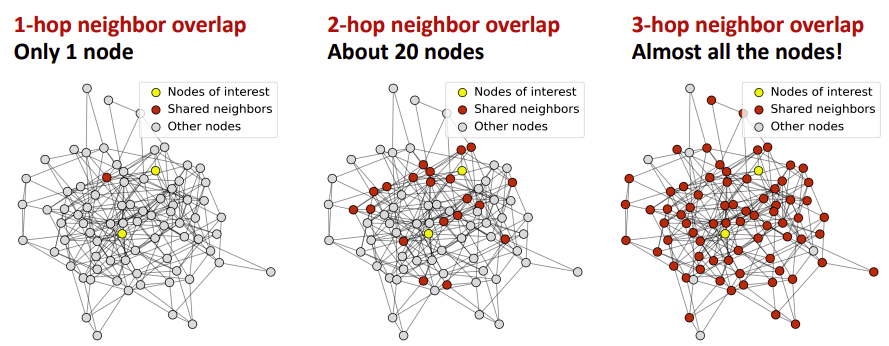

This issue can be formalized by defining the influence of each nodes input feature $h_u^{(0)} = x_u$ on the final layer embedding of all nodes in the graph $h_v^{(k)} \ \forall v \in V$.  
An important theorem states that if we use self-loops the influence of $u$ on $v$ after $k$ iterations is proportional to the probability of visinting node $v$ of a length $k$ random walk starting from $u$

We will present some solutions.

### Skip connections
A simple idea is to use the old embedding somehow after applying the $\update$ function.

photo from cs224w 2021  
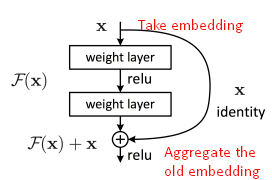

**Concatenation**
$$\update_{\text{concat}}\left(h_u, m_{N(u)}\right) = \left[ \update_{\text{base}}\left(h_u, m_{N(u))}\right) \ | \ h_u \right]$$

**Interpolation**
$$\update_{\text{interpolate}}\left (h_u, m_{N(u)} \right) = \alpha_1 \cdot \update_{\text{base}}\left( h_u, m_{N(u)} \right) \ + \alpha_2 \cdot h_u $$
Where $\alpha_1, \alpha_2 \in [0, 1]^d$ and $\alpha_2 = 1 - \alpha_1$

### Recurrent neural networks
Since recurrent neural networks take into consideration history they can be used as an update function to alleviate the over-smoothing problem
$$h_u^{k} = \update\left(h_u, m_{N(u)}\right) = \text{RNN}(h_u, m_{N(u))})$$

### Jumping knolwedge connections

Usually we used the output of the GNN (last layer embedding) as a node representation. However we are not forced to do this. We can define the node representation $z_u$ as a combinations of messages from different steps:
$$z_u = f_{jk}\left(h_u^{(0)} \ | \ h_u^{(1)} \ | ... \ | \ h_u^{(k)}\right)$$
where $f_{jk}$ is a differentiable function. 

### Add layers in smart places

There are places where you can add layers to increase expresiveness. Let's explore 2 options

**Add within the GNN layer**  
In the GNN framework the $\update$ and $\aggregate$ functions used only 1 layer to transform the embeddings ($WH$). We are not forced to do this, we can use deeper models $\text{MLP}(H)$

**Add layers that do not pass messages**  
Not every layer must pass messages. We can add layers that preprocess our features and postprocess the results. Example: If our node features are images we might want to apply some 2d convolutions on them to compute new features before applying the GNN layer.

photo from cs224w 2021  
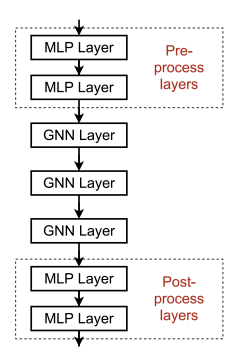


# Code

In [1]:
import itertools
import os
import random
import sys
import time

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy
import scipy.stats as st
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
parent_dir = os.path.abspath(os.path.join(".."))
if not parent_dir in sys.path:
    sys.path.append(parent_dir)

# from utils.utils import average_clustering, average_degree, connectivity_perc, giant_component, communities_to_dict, dict_to_communities, load_graph
from utils.pyg_utils import print_data, print_dataset

## Load and inspect data

PyG models graphs using the `Data` class. Given a graph $G = (X_n, (I, X_e))$ where 
- $X_n \in \mathbb R^{|V| \times d_n}$ are node features of dimension $d_n$, 
- $X_e \in \mathbb R^{|E| \times d_e}$ are edge features of dimension $d_e$, and 
- $I \in \mathbb R^{2 \times |E|}$ are the edge indices.   

The data object keeps these features in the following format:

- `data.x`: Node feature matrix with shape `[num_nodes, num_node_features]`
- `data.edge_index`: Graph connectivity in COO format with shape `[2, num_edges]` and type `torch.long`
- `data.edge_attr`: Edge feature matrix with shape `[num_edges, num_edge_features]`
- `data.y`: Target to train against (may have arbitrary shape), e.g., node-level targets of shape `[num_nodes, *]` or graph-level targets of shape `[1, *]`
- `data.pos`: Node position matrix with shape `[num_nodes, num_dimensions]`

**COO format**
`edge_index` -- COO format (coordinate format) commonly used for representing sparse matrices. Instead of holding the adjacency information in a dense representation $A \in \{0,1\}^{|V|\times|V|}$, PyG represents graphs sparsely, which refers to only holding the coordinates/values for which entries in $A$ are **non-zero**.


In [3]:
import torch
import torch.nn.functional as F
import torch_geometric
import torch_geometric.nn as pyg_nn
import torch_geometric.transforms as pyg_T
from ogb.nodeproppred import Evaluator, PygNodePropPredDataset
from torch import nn
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import Planetoid, TUDataset
from torch_geometric.utils import from_networkx, to_networkx
from tqdm.notebook import tqdm

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device = }")

device = 'cuda'


In [5]:
dataset = Planetoid(root=os.path.join("..", "data", "tmp", "Cora"), name="Cora")
data = dataset[0]
data.to(device)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

## Graph convolution model

If needed install this https://github.com/cthoyt/class-resolver

In [6]:
from torch_geometric.nn import GCN, MLP, GCNConv, GATConv
from torchinfo import summary

In [7]:
model = GCN(
    in_channels=dataset.num_features,
    hidden_channels=64,
    out_channels=dataset.num_classes,
    num_layers=2,
)
summary(model)

Layer (type:depth-idx)                   Param #
GCN                                      --
├─ReLU: 1-1                              --
├─ModuleList: 1-2                        --
│    └─GCNConv: 2-1                      64
│    │    └─SumAggregation: 3-1          --
│    │    └─Linear: 3-2                  91,712
│    └─GCNConv: 2-2                      7
│    │    └─SumAggregation: 3-3          --
│    │    └─Linear: 3-4                  448
├─TrimToLayer: 1-3                       --
Total params: 92,231
Trainable params: 92,231
Non-trainable params: 0

In [8]:
class GNNModel(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        num_layers:int = 1,
        return_embeds: bool = False,
        conv: str = "gcn",
    ):

        if conv == "gcn":
            conv = GCNConv
        elif conv == "gat":
            conv = GATConv

        super().__init__()
        # Config
        self.return_embeds = return_embeds
        
        # List of GCN conv layers layers
        self.convs = torch.nn.ModuleList()
        if num_layers >= 1:
            self.convs.append(conv(in_channels=in_channels, out_channels=hidden_channels))
        for _ in range(num_layers-1):
            self.convs.append(conv(in_channels=hidden_channels, out_channels=hidden_channels))

        # Post processing
        self.classifier = nn.Linear(hidden_channels, out_channels)
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self, x, edge_index):

        for i, layer in enumerate(self.convs):
            x = layer(x, edge_index)
        x = self.classifier(x)
        out = self.softmax(x)
        if self.return_embeds:
            return out, x
        else:
            return out

In [9]:
# Initialize model and parameters

print(dataset.num_features, dataset.num_classes)
model = GNNModel(
    in_channels = dataset.num_features,
    hidden_channels = 64,
    out_channels = dataset.num_classes,
    num_layers = 2,
).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = torch.nn.CrossEntropyLoss()

1433 7


In [10]:
summary(model)

Layer (type:depth-idx)                   Param #
GNNModel                                 --
├─ModuleList: 1-1                        --
│    └─GCNConv: 2-1                      64
│    │    └─SumAggregation: 3-1          --
│    │    └─Linear: 3-2                  91,712
│    └─GCNConv: 2-2                      64
│    │    └─SumAggregation: 3-3          --
│    │    └─Linear: 3-4                  4,096
├─Linear: 1-2                            455
├─Softmax: 1-3                           --
Total params: 96,391
Trainable params: 96,391
Non-trainable params: 0

In [11]:
# Training and evaluation functions
def train_epoch(model, data, train_idx, optimizer, loss_function):

    # Don't forget these!
    model.train()
    optimizer.zero_grad()

    # Get predictions, compute loss and backprop
    out = model(data.x, data.edge_index)
    loss = loss_function(out[train_idx], data.y[train_idx])
    acc = torch.sum(
        data.y[train_idx] == torch.argmax(out[train_idx], dim=1)
    ) / len(data.y[train_idx])

    loss.backward()
    optimizer.step()

    return loss.item(), acc.item()


@torch.no_grad()
def eval_epoch(model, data, val_idx, loss_function):
    # We don't need the gradients for evaluation!
    model.eval()
    out = model(data.x, data.edge_index)
    loss = loss_function(out[val_idx], data.y[val_idx])
    acc = torch.sum(data.y[val_idx] == torch.argmax(out[val_idx], dim=1)) / len(
        data.y[val_idx]
    )

    return loss.item(), acc.item()

In [12]:
epochs = 100
for epoch in tqdm(range(1, epochs + 1)):
    loss_train, acc_train = train_epoch(
        model, data, data.train_mask, optimizer, loss_function
    )
    loss_val, acc_val = eval_epoch(model, data, data.val_mask, loss_function)

    if epoch % 20 == 0:
        print(
            f"{epoch = } | {loss_train=: .2f} {acc_train=: .2f} \t {loss_val=: .2f} {acc_val=: .2f}"
        )

  0%|          | 0/100 [00:00<?, ?it/s]

epoch = 20 | loss_train= 1.79 acc_train= 0.91 	 loss_val= 1.87 acc_val= 0.61
epoch = 40 | loss_train= 1.40 acc_train= 0.99 	 loss_val= 1.64 acc_val= 0.76
epoch = 60 | loss_train= 1.21 acc_train= 0.99 	 loss_val= 1.49 acc_val= 0.77
epoch = 80 | loss_train= 1.18 acc_train= 1.00 	 loss_val= 1.45 acc_val= 0.76
epoch = 100 | loss_train= 1.17 acc_train= 1.00 	 loss_val= 1.44 acc_val= 0.76


In [13]:
loss, acc = eval_epoch(model, data, data.test_mask, loss_function)
loss, acc

(1.4265334606170654, 0.7820000648498535)

In [14]:
# Let's look at some embeddings
model.return_embeds = True
with torch.no_grad():
    _, emb = model(data.x, data.edge_index)

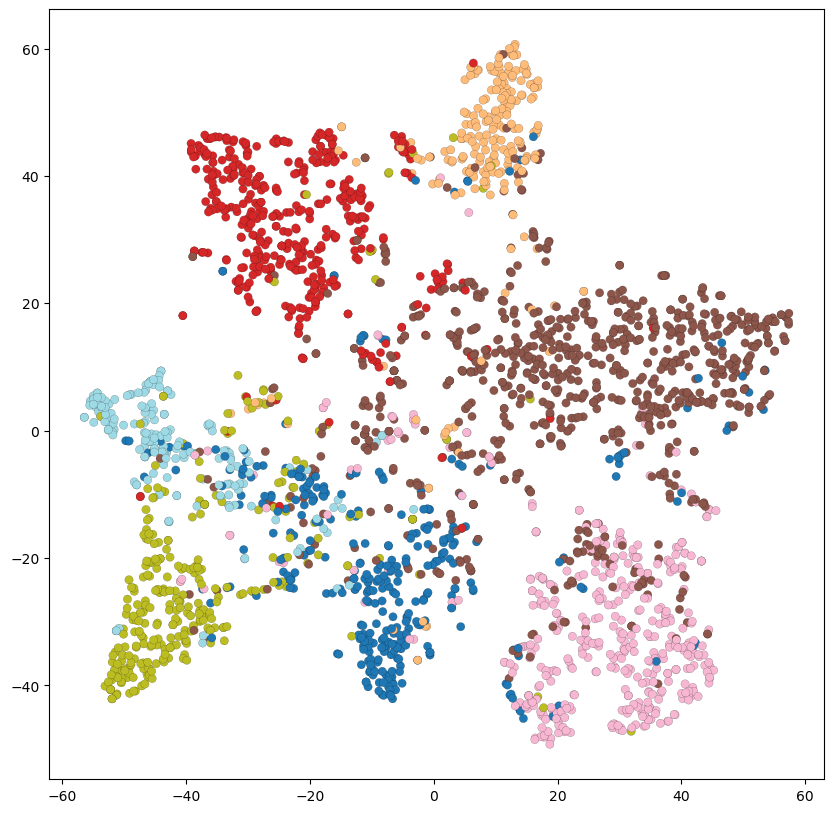

In [15]:
cora_color = data.y.cpu()
plt.figure(figsize=(10, 10))
plt.scatter(
    *TSNE(n_components=2).fit_transform(emb.cpu().detach().numpy()).T,
    c=cora_color,
    cmap=plt.cm.tab20,
    edgecolors="black",
    linewidths=0.1
)

plt.show()

## Deep Dive

### torch_scatter
- https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html#torch_scatter.scatter

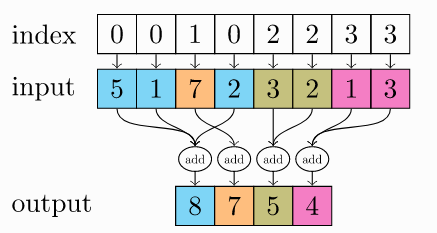

In [16]:
from torch_geometric.utils import scatter

In [17]:
src = torch.randint(low=0, high=10, size=(6,))
index = torch.tensor([0, 1, 0, 1, 2, 1])

out = scatter(src, index, dim=0, reduce="sum")

print(src)
print(index)
print(out)

tensor([2, 3, 8, 4, 6, 9])
tensor([0, 1, 0, 1, 2, 1])
tensor([10, 16,  6])


### MessagePassing class

The `MessagePassing` class - [tutorial](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html) and [docs](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.message_passing.MessagePassing)

Methods:
- `MessagePassing(aggr="add", flow="source_to_target", node_dim=-2)` -- Defines aggregation scheme and the flow direction of message passing. `node_dim` indicates along which axis to propagate
- `MessagePassing.propagate(edge_index, size, **kwargs)` -- Initial call to start propagating messages
- `MessagePassing.message(...)` -- Constructs messages to node $i$. Can take any argument which was passed to `propagate()`. In addition, tensors passed to `propagate()` can be mapped to the respective nodes $i$ and $j$ by appending `_i` or `_j` to the variable name. ($i$ is the central node and $j$ are the neighbours) 
- `MessagePassing.update(aggr_out, ...)` -- Updates node embeddings. Takes in the output of aggregation as first argument and any argument which was initially passed to `propagate()`

Propagate flow:
1. `.propagate(edge_index, size, **kwargs)` is called.
2. `.propagate()` calls `.message()` and passes extra `kwargs` to it
3. `.message()` computes messages and returns them.
4. `.propagate()` then calls `.aggregate(inputs, index)`  and passes the outputs of `.message()` as `inputs`. `.aggregate()` usually behaves based on `*.scatter()`. 
5. `aggregate()` aggregates outputs and returns them
6. `propagate()` then calls `.update(inputs, **kwargs)` with and passes the outputs of `.aggregate()` as `inputs` and extra `kwargs`. 
7. `.update()` computes the final update and returns them
8. `.propagate()` returns the outputs of `.update()`


To understand the `MessagePassing` class we will consider the following graph and where each node has a 1-dimensional feature

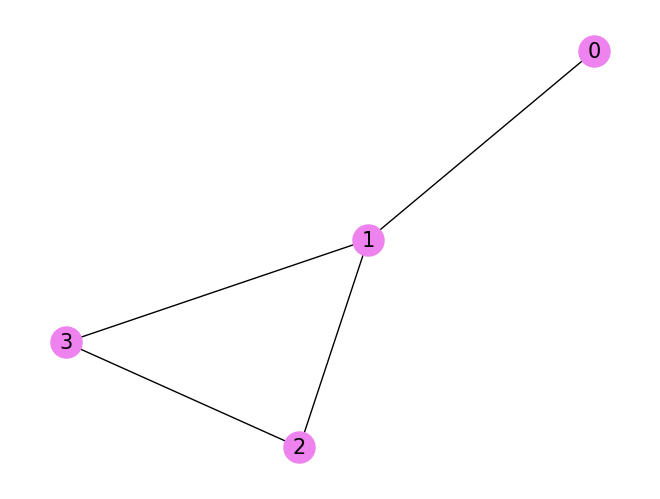

In [18]:
G = nx.Graph([(0, 1), (1, 2), (1, 3), (2, 3)])
pos = nx.spring_layout(G, seed=42)
nx.draw(
    G,
    pos=pos,
    with_labels=True,
    node_color="violet",
    node_size=500,
    font_size=15,
)

In [38]:
data = from_networkx(G)

x = torch.tensor(
    [
        [0],
        [10],
        [20],
        [30],
    ],
    dtype=torch.float,
)

x = torch.tensor(
    [
        [0, 0],
        [10, 100],
        [20, 200],
        [30, 300],
    ],
    dtype=torch.float,
)
data.x = x

print(data)

Data(edge_index=[2, 8], num_nodes=4, x=[4, 2])


We will construct the following layer: $$h_u = b \cdot h_u + \sum_{v\in N(u)}\dfrac {h_u} {2a} + \dfrac {h_v} a$$ where $a, b$ are given


In [45]:
from torch_geometric.nn import MessagePassing


class MPLayer(MessagePassing):
    def __init__(self, a, b):
        super().__init__()
        self.a = a
        self.b = b

    def forward(self, x, edge_index):
        """Forward function

        Parameters
        ----------
        x : Tensor of shape (n_nodes, n_channels)
            Input features

        edge_index : Tensor of shape (2, n_edges)
            Graph edges

        Returns
        -------
        Tensor
        """

        # This computes messages then aggregates them
        out = self.propagate(edge_index, x=(x, x), a=self.a, b=self.b)

        # out = self.b * x + m  # -- this line can replace the whole update functions

        return out

    def message(self, x_i, x_j, a):
        """Message passing

        Parameters
        ----------
        x_i : Tensor of shape (n_edges, n_features)
            Features of the source nodes

        x_j : Tensor of shape (n_edges, n_features)
            Features of the neighbour nodes

        a : int

        Returns
        -------
        Tensor of shape (n_edges, n_features)
            The message from each edge to the source node
        """

        out = x_i / (2 * a) + x_j / a

        print("Message function\n")
        print(f"{x_i.shape=}")
        print(f"{x_j.shape=}")
        print(f"{out.shape=}")
        print(f"{x_i.T=}")
        print(f"{x_j.T=}")
        print(f"{out.T=}")
        print()

        return out

    def aggregate(self, inputs, index, dim_size=None):
        """Aggregate the computed messages

        Parameters
        ----------
        inputs : Tensor
            output from message

        index : Tensor
            The index passed to scatter

        dim_size : int, default=None

        Returns
        -------
        Tensor  of shape (n_nodes, n_features)
            The aggregated message
        """
        # `inputs` come from the output of the self.message function

        out = scatter(inputs, index, dim=0, reduce="sum")

        print("Aggregate function\n")
        print(f"Aggregate inputs: \n{inputs.T=}\n{index.T=}")
        print(f"{out.T = }")
        print()

        return out

    def update(self, inputs, x, b):
        """Update function

        Parameters
        ----------
        inputs : Tensor of shape (n_nodes, n_features)
            Output from aggregate

        x : Tuple of Tensors of shape (n_nodes, n_features)
            source, destination nodes

        b : int
            parameter

        Returns
        -------
        Tensor
            Next embedding
        """
        src, dest = x
        out = b * src + inputs

        print("Update function\n")
        print(f"Inputs: \n{inputs.T=}\n{x=}")
        print(f"Outputs \n{out.T=}")

        return out

    def propagate(self, edge_index, size=None, **kwargs):
        """Simple propagate built after
        https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/conv/message_passing.html#MessagePassing.propagate

        """

        size = self._check_input(edge_index, size)

        coll_dict = self._collect(
            self._user_args, edge_index, size, kwargs
        )
        # Message
        msg_kwargs = self.inspector.distribute("message", coll_dict)
        out = self.message(**msg_kwargs)
        # Aggregate
        aggr_kwargs = self.inspector.distribute("aggregate", coll_dict)
        out = self.aggregate(out, **aggr_kwargs)
        # Update
        update_kwargs = self.inspector.distribute("update", coll_dict)
        out = self.update(out, **update_kwargs)

        return out

In [46]:
mpl = MPLayer(a=2, b=100)

In [47]:
mpl.inspector.params

{'message': OrderedDict([('x_i', <Parameter "x_i">),
              ('x_j', <Parameter "x_j">),
              ('a', <Parameter "a">)]),
 'aggregate': OrderedDict([('index', <Parameter "index">),
              ('dim_size', <Parameter "dim_size=None">)]),
 'message_and_aggregate': OrderedDict(),
 'update': OrderedDict([('x', <Parameter "x">), ('b', <Parameter "b">)]),
 'edge_update': OrderedDict()}

In [48]:
mpl(data.x, data.edge_index)

Message function

x_i.shape=torch.Size([8, 2])
x_j.shape=torch.Size([8, 2])
out.shape=torch.Size([8, 2])
x_i.T=tensor([[ 10.,   0.,  20.,  30.,  10.,  30.,  10.,  20.],
        [100.,   0., 200., 300., 100., 300., 100., 200.]])
x_j.T=tensor([[  0.,  10.,  10.,  10.,  20.,  20.,  30.,  30.],
        [  0., 100., 100., 100., 200., 200., 300., 300.]])
out.T=tensor([[  2.5000,   5.0000,  10.0000,  12.5000,  12.5000,  17.5000,  17.5000,
          20.0000],
        [ 25.0000,  50.0000, 100.0000, 125.0000, 125.0000, 175.0000, 175.0000,
         200.0000]])

Aggregate function

Aggregate inputs: 
inputs.T=tensor([[  2.5000,   5.0000,  10.0000,  12.5000,  12.5000,  17.5000,  17.5000,
          20.0000],
        [ 25.0000,  50.0000, 100.0000, 125.0000, 125.0000, 175.0000, 175.0000,
         200.0000]])
index.T=tensor([1, 0, 2, 3, 1, 3, 1, 2])
out.T = tensor([[  5.0000,  32.5000,  30.0000,  30.0000],
        [ 50.0000, 325.0000, 300.0000, 300.0000]])

Update function

Inputs: 
inputs.T=tensor([[ 

C:\Users\ZademnW\AppData\Local\Temp\ipykernel_528\2101363049.py:88: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3575.)
  print(f"Aggregate inputs: \n{inputs.T=}\n{index.T=}")


tensor([[5.0000e+00, 5.0000e+01],
        [1.0325e+03, 1.0325e+04],
        [2.0300e+03, 2.0300e+04],
        [3.0300e+03, 3.0300e+04]])

## GCN layer

Now we shall implement hte [GCN layer](https://arxiv.org/abs/1609.02907) defined as
$$h_u^{k} = \sum_{v \in N(u) \cup \{u\}} \dfrac 1 {\sqrt{|N(u)|\cdot |N(v)|}} \cdot \left(Wh_v^{(k-1)}\right)$$

In [49]:
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

In [69]:
layer = torch.nn.Linear(2, 4)
layer

Linear(in_features=2, out_features=4, bias=True)

In [70]:
layer.weight

Parameter containing:
tensor([[-0.6260,  0.0803],
        [-0.6933,  0.6699],
        [ 0.1658, -0.2345],
        [-0.5428,  0.4127]], requires_grad=True)

In [76]:
dataset = Planetoid(root=os.path.join("..", "data", "tmp", "Cora"), name="Cora")
data = dataset[0]
# data.to(device)

In [77]:
print(data.edge_index.shape)
print(add_self_loops(data.edge_index)[0].shape)

torch.Size([2, 10556])
torch.Size([2, 13264])


In [78]:
class GCNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        # 5. Define aggregation function
        super(GCNLayer, self).__init__(aggr="add")
        self.lin = torch.nn.Linear(
            in_channels, out_channels
        )  # Linear layer for W
        # self.device = device
        # self.to(device)

    def forward(self, x, edge_index):
        # 1. Add self loops
        # edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        # 2. Perform the linear transformation with W
        x = self.lin(x)
        # 3. Normalize
        row, col = edge_index
        # Compute the degree for each node. It will have len 4 because there are 4 nodes
        deg = degree(col, num_nodes=x.size(0), dtype=x.dtype)
        # We invert and square root the degrees
        deg_inv_sqrt = deg.pow(-0.5)
        # This produces `inf` on nodes that have no neighbours. So we set inf to 0
        deg_inv_sqrt[deg_inv_sqrt == float("inf")] = 0
        # 4. Propagate. We pass the computed normalization
        return self.propagate(edge_index, x=x, d=deg_inv_sqrt.view(-1, 1))

    def message(self, x_i, x_j, d_i, d_j):
        # x_j has shape [E, out_channels]
        # 4. Normalize node features.
        # Normalize self features
        out = x_i * d_i * d_i
        # Normalize neighbour features
        out = out + x_j * d_i * d_j
        return out
        # return norm.view(-1, 1) * x_j

In [79]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [80]:
layer = GCNLayer(in_channels=data.num_features, out_channels=16)

In [81]:
layer(data.x, data.edge_index)

tensor([[-0.0518,  0.0180,  0.0426,  ..., -0.0288,  0.1151,  0.0597],
        [ 0.0826, -0.0106, -0.0865,  ...,  0.1067, -0.1933, -0.0778],
        [ 0.1884, -0.0488, -0.0844,  ...,  0.1508,  0.0102, -0.0868],
        ...,
        [ 0.0578, -0.0043,  0.0437,  ..., -0.0679,  0.1238, -0.0334],
        [-0.0674, -0.1486, -0.0878,  ..., -0.0289, -0.0875, -0.0194],
        [ 0.0503, -0.0837, -0.0602,  ...,  0.0947, -0.0660,  0.0210]],
       grad_fn=<ScatterAddBackward0>)

In [82]:
data.to(device)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [83]:
layer = GCNLayer(in_channels=data.num_features, out_channels=16).to(device)

In [84]:
emb = layer(data.x, data.edge_index)

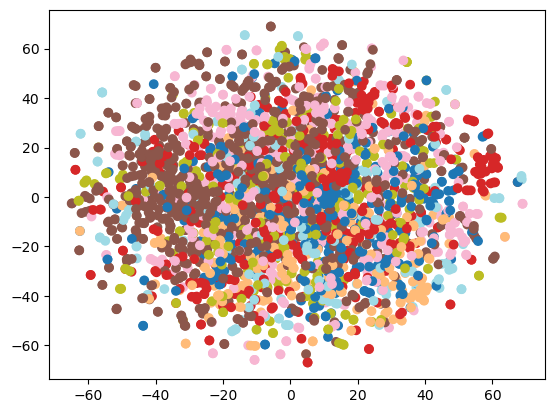

In [85]:
# Try to pca the embeddings
cora_color = data.y.cpu()
# plt.scatter(*PCA(n_components=2).fit_transform(emb).T, c = cora_color, cmap = plt.cm.tab20)
plt.scatter(
    *TSNE(n_components=2).fit_transform(emb.cpu().detach().numpy()).T,
    c=cora_color,
    cmap=plt.cm.tab20
)
# plt.scatter(*UMAP(n_components=2).fit_transform(emb).T, c = cora_color, cmap = plt.cm.tab20)

plt.show()

In [86]:
model = pyg_nn.Sequential(
    "x, edge_index",
    [
        (
            GCNLayer(in_channels=dataset.num_features, out_channels=64),
            "x, edge_index -> x",
        ),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=64, out_features=dataset.num_classes),
        nn.Softmax(dim=1),
    ],
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = torch.nn.CrossEntropyLoss()

summary(model)

Layer (type:depth-idx)                   Param #
Sequential_f0dec7                        --
├─GCNLayer: 1-1                          --
│    └─SumAggregation: 2-1               --
│    └─Linear: 2-2                       91,776
├─ReLU: 1-2                              --
├─Linear: 1-3                            455
├─Softmax: 1-4                           --
Total params: 92,231
Trainable params: 92,231
Non-trainable params: 0

In [87]:
epochs = 100
for epoch in tqdm(range(1, epochs + 1)):
    loss_train, acc_train = train_epoch(
        model, data, data.train_mask, optimizer, loss_function
    )
    loss_val, acc_val = eval_epoch(model, data, data.val_mask, loss_function)

    if epoch % 20 == 0:
        print(
            f"{epoch = } | {loss_train=: .2f} {acc_train=: .2f} \t {loss_val=: .2f} {acc_val=: .2f}"
        )

  0%|          | 0/100 [00:00<?, ?it/s]

epoch = 20 | loss_train= 1.75 acc_train= 0.99 	 loss_val= 1.87 acc_val= 0.64
epoch = 40 | loss_train= 1.37 acc_train= 1.00 	 loss_val= 1.72 acc_val= 0.71
epoch = 60 | loss_train= 1.21 acc_train= 1.00 	 loss_val= 1.63 acc_val= 0.71
epoch = 80 | loss_train= 1.18 acc_train= 1.00 	 loss_val= 1.59 acc_val= 0.71
epoch = 100 | loss_train= 1.17 acc_train= 1.00 	 loss_val= 1.58 acc_val= 0.70


In [88]:
# Let's look at some embeddings
with torch.no_grad():
    emb = model[0](data.x, data.edge_index)

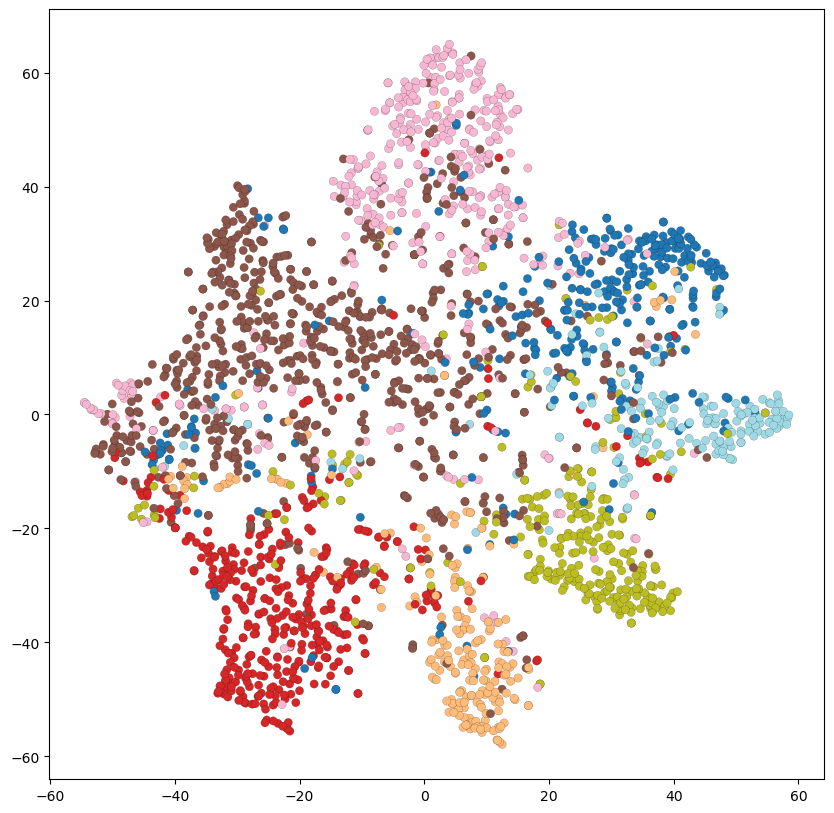

In [89]:
cora_color = data.y.cpu()
plt.figure(figsize=(10, 10))
plt.scatter(
    *TSNE(n_components=2).fit_transform(emb.cpu().detach().numpy()).T,
    c=cora_color,
    cmap=plt.cm.tab20,
    edgecolors="black",
    linewidths=0.1
)

plt.show()

## Neighbourhood attention 
- [GAT paper](https://arxiv.org/pdf/1710.10903.pdf)
- [Repository with GAT](https://github.com/gordicaleksa/pytorch-GAT#what-are-gnns)
- [DeepFindr video](https://www.youtube.com/watch?v=A-yKQamf2Fc&t)
- [WelcomeAIOverlords video](https://www.youtube.com/watch?v=SnRfBfXwLuY)

When we presented $\aggregate$ functions we treated every neighbour the same. For example when we summed them everyone had the same importance in the sum. But a strategy to improve the aggregation layer is to treat neighbours differently making one neighbour more important than another. This concept is called assigning **attention weights** to neighbours.

$$m_{N(u)} = \sum_{v \in N(u)}\alpha_{uv}h_v$$

Where $\alpha_{uv}$ is the attention weight  
In the previous cases $\alpha_{uv} = \dfrac 1 {|N(u)|}$ was the same $\Rightarrow$ all neighbours are equally important.

We want the neural network to devote more computing power (attention) on one small but important part of data. The attention weight $\alpha_{uv}$ depends on the context and is learned through training.

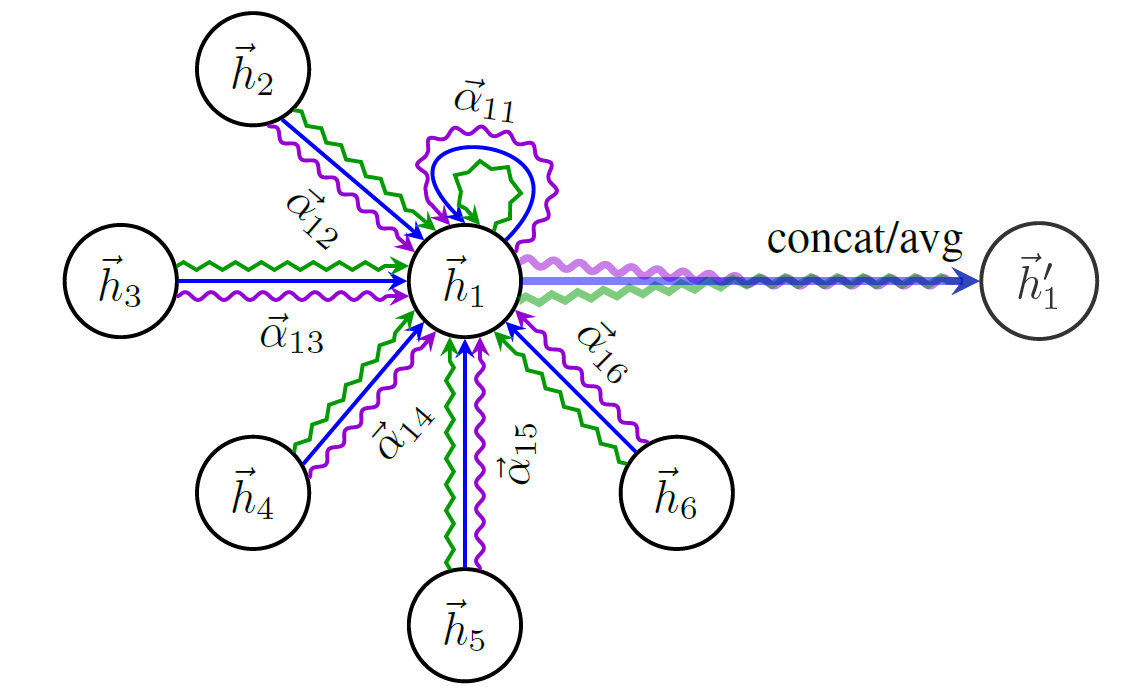

### Attention mechanism

Let $a$ be our attention function. Then for a node u and each of his neighbours $v \in N(u)$ we want to compute the attention coefficient: 
$$e_{uv} = a\left(W^{(k)}h_u^{(k-1)},\ W^{(k)} h_v^{(k-1)}\right)$$

After computing the coefficients of the neighbours of $u$ we want to normalize them to compute the attention weights $\alpha_{vu}$. Let's apply the softmax function:

$$\alpha_{uv} = \text{softmax}(e_{uv}) = \dfrac {\exp(e_{uv})} {\sum_{k \in N(u)} \exp(e_{uk})}$$

Then our new way to compute the node embeddings becomes:
$$h_u^{(k)} = \left( \sum_{v \in N(u)} \alpha_{uv} W^{(k)} h_u^{(k-1)}\right)$$

**OK, but how does the attention mechanism $a$ look like?**

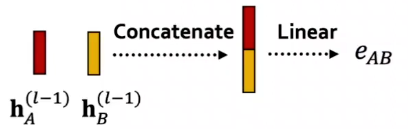

The basic approach is to concatenate the embeddings and pass them through a linear layer
$$e_{uv} = \text{Lin}\left(W^{(k)}h_u^{(k-1)} \ |  \ W^{(k)}h_u^{(k-1)}\right)$$

We can use other approaches such as averaging or pooling the embeddings before passing them. Check the paper to see how the original GAT is designed

In [90]:
from torch_geometric.nn import GATConv

In [91]:
# ?GATConv

In [92]:
# Initialize model and parameters

print(dataset.num_features, dataset.num_classes)
model = GNNModel(
    in_channels = dataset.num_features,
    hidden_channels = 64,
    out_channels = dataset.num_classes,
    num_layers = 1,
    conv = "gat"
).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = torch.nn.CrossEntropyLoss()

1433 7


In [93]:
summary(model)

Layer (type:depth-idx)                   Param #
GNNModel                                 --
├─ModuleList: 1-1                        --
│    └─GATConv: 2-1                      192
│    │    └─SumAggregation: 3-1          --
│    │    └─Linear: 3-2                  91,712
│    │    └─Linear: 3-3                  (recursive)
├─Linear: 1-2                            455
├─Softmax: 1-3                           --
Total params: 92,359
Trainable params: 92,359
Non-trainable params: 0

In [94]:
epochs = 100
for epoch in tqdm(range(1, epochs + 1)):
    loss_train, acc_train = train_epoch(
        model, data, data.train_mask, optimizer, loss_function
    )
    loss_val, acc_val = eval_epoch(model, data, data.val_mask, loss_function)

    if epoch % 20 == 0:
        print(
            f"{epoch = } | {loss_train=: .2f} {acc_train=: .2f} \t {loss_val=: .2f} {acc_val=: .2f}"
        )

  0%|          | 0/100 [00:00<?, ?it/s]

epoch = 20 | loss_train= 1.82 acc_train= 0.99 	 loss_val= 1.89 acc_val= 0.68
epoch = 40 | loss_train= 1.48 acc_train= 0.98 	 loss_val= 1.75 acc_val= 0.72
epoch = 60 | loss_train= 1.24 acc_train= 0.99 	 loss_val= 1.63 acc_val= 0.70
epoch = 80 | loss_train= 1.19 acc_train= 0.99 	 loss_val= 1.59 acc_val= 0.69
epoch = 100 | loss_train= 1.17 acc_train= 1.00 	 loss_val= 1.57 acc_val= 0.71


In [95]:
loss, acc = eval_epoch(model, data, data.test_mask, loss_function)
loss, acc

(1.5664690732955933, 0.7000000476837158)

In [96]:
# Let's look at some embeddings
model.return_embeds = True
with torch.no_grad():
    _, emb = model(data.x, data.edge_index)

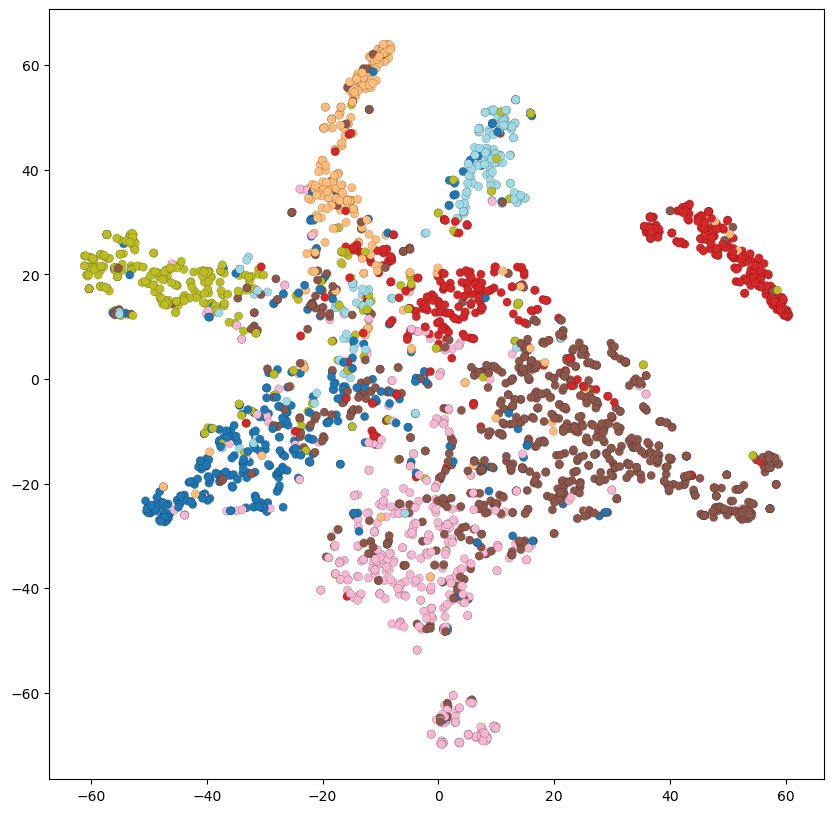

In [97]:
cora_color = data.y.cpu()
plt.figure(figsize=(10, 10))
plt.scatter(
    *TSNE(n_components=2).fit_transform(emb.cpu().detach().numpy()).T,
    c=cora_color,
    cmap=plt.cm.tab20,
    edgecolors="black",
    linewidths=0.1
)

plt.show()